In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Transformations

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Loading Dataset

In [3]:
train_dataset = MNIST('data', train=True, download=True, transform=transform)
test_dataset = MNIST('data', train=False, transform=transform)

# Partitioning the Dataset into two classes

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

# Wraping with iterator

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Draw the data

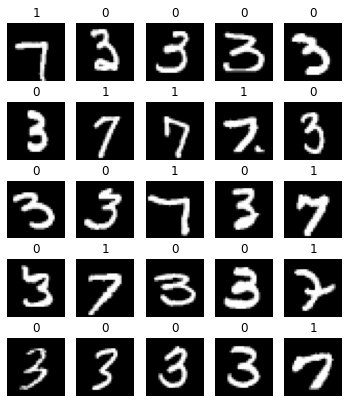

In [9]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# The Task

After trying to figure out the mechanism of forward and backward propagation I desided, that the given code architecture was too complicated and messy to deal with. I googled and found a definitive guide on how to perform the task more elegantly. I used the code from this [page](https://jessequinn.info/blog/articles/mlp-numpy) as a basic architecture, adding and modifing parts if I needed to.

In [6]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    - Process input to get output:           output = layer.forward(input)
        - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
        Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
            # A dummy layer does nothing
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        d_layer_d_input = np.eye(num_units)

        return np.dot(grad_output, d_layer_d_input) # chain rule

In [7]:
'''
Activation function Rectified Linear Units (ReLU)
f(x) = max(0, X)
ReLU function is a simple function which is zero for any 
input value below zero and the same value for values greater than zero.
'''
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass

    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0, input)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output * relu_grad 

In [92]:
'''

'''
class Sigmoid(Layer):
    def __init__(self):
        """Sigmoid layer simply applies elementwise sigmoid to all inputs"""
        pass

    def forward(self, input):
        """Apply elementwise Sigmoid to [batch, input_units] matrix"""
        return 1 / (1 + np.exp(-input))
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Sigmoid input"""
        sigmoid_input = self.forward(input)
        sigmoid_grad = sigmoid_input * (1 - sigmoid_input)
        return grad_output * sigmoid_grad

In [93]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        self.grad_w = None

    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)       
        grad_weights = input.T @ grad_output
        self.grad_w = grad_weights
        grad_biases = grad_output.sum(axis=0)       
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

In [94]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]

    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

In [111]:
def compute_bce_cost(Y, P_hat):
    """
    This function computes Binary Cross-Entropy(bce) Cost and returns the Cost and its
    derivative.
    This function uses the following Binary Cross-Entropy Cost defined as:
    => (1/m) * np.sum(-Y*np.log(P_hat) - (1-Y)*np.log(1-P_hat))

    Args:
        Y: labels of data
        P_hat: Estimated output probabilities from the last layer, the output layer

    Returns:
        cost: The Binary Cross-Entropy Cost result
        dP_hat: gradient of Cost w.r.t P_hat

    """
    m = Y.shape[0]  # m -> number of examples in the batch

    cost = (1 / m) * np.sum(-Y * np.log(P_hat) - (1 - Y) * np.log(1 - P_hat))
    cost = np.squeeze(cost)  # remove extraneous dimensions to give just a scalar (e.g. this turns [[17]] into 17)

    dP_hat = (1 / m) * (-(Y / P_hat) + ((1 - Y) / (1 - P_hat)))

    return cost, dP_hat

In [112]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
        activations.append(layer.forward(input))
        input = activations[-1]

    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Compute network predictions.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

def train(network, X, y, loss='softmax'):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.

    After you called backward for all layers, all Dense layers have already made one gradient step.
    """

    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]

    # Compute the loss and the initial gradient
    if loss == "softmax":
        loss = softmax_crossentropy_with_logits(logits, y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
    elif loss == "bce":
        loss, loss_grad = compute_bce_cost(y, logits)

    for i in range(len(network))[::-1]:
        layer = network[i]
        loss_grad = layer.backward(layer_inputs[i], loss_grad)

    return np.mean(loss)

In [96]:
sample_x, sample_y = next(iter(train_loader))
sample_x = sample_x.view(sample_x.shape[0], -1).numpy()
sample_y = np.expand_dims(sample_y.numpy(), 1)

In [127]:
network = []
network.append(Dense(sample_x.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 100))
network.append(ReLU())
network.append(Dense(100, 1))
network.append(Sigmoid())

In [128]:
EPOCHS = 5

In [129]:
losses = []

for n_epoch in range(EPOCHS):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        current_loss = train(network, x, y, loss='bce')
        losses.append(current_loss)
    print(losses[-1])

Epoch: 1
0.0987678253493521
Epoch: 2
0.08374951203119531
Epoch: 3
0.06982609972482225
Epoch: 4
0.03189312947224351
Epoch: 5
0.027462336904688318


In [131]:
np.mean(losses)

0.11027888145039118

Text(0, 0.5, 'Loss function')

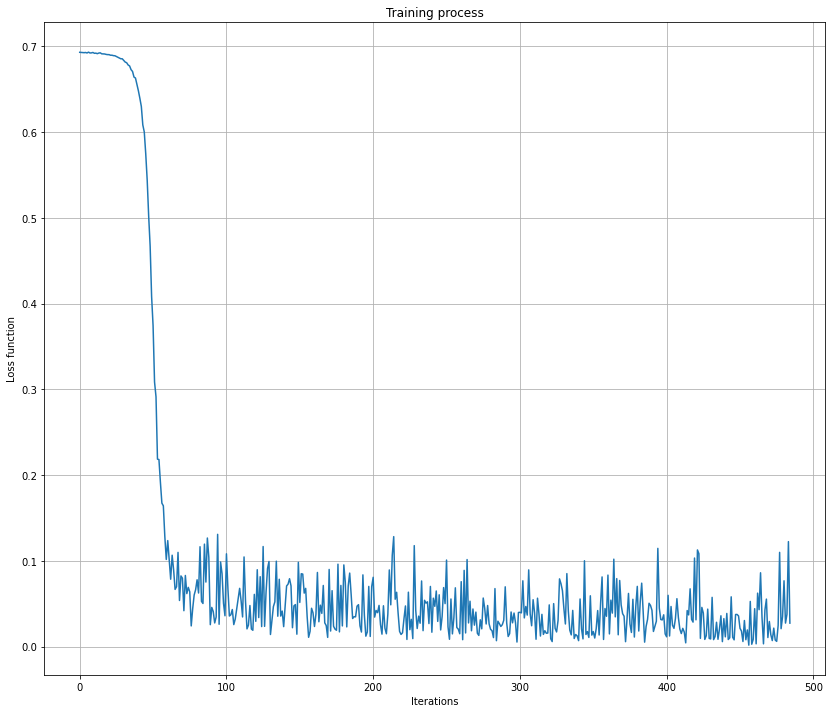

In [130]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')